## Checkpoint code
> This notebook contains check point code - data analysis of "LLM for medical triage" audit.
### Authors: *Huize Mao*, *Bhagya Ram*

---

### Background:
Large language models (LLMs) are already being used for mental health support, including crisis guidance, safety recommendations, and therapeutic-style responses, and they are being tested for clinical decision support in triage, referral, and early diagnosis. We ran an audit to see if LLM respond differently about urgency of a mental health case based on patients' demographic such as `age`, `profession`, `race_ethnicity`, or `gender`. For this, we queried major LLMs from Google, Amazon, and OpenAI, gathering **20159** data points to uncover potential biases embedded in the models.

### Motivation:
#### In this notebook, we want to explrore three different aspects to the audit data.
1. Does different model generally give different "baseline" scores for medical triaging?
2. Does age correlate the urgency score?
3. Does race correlate the urgency score?
4. Does gender correlate the urgency score within each models?
5. Does language spoken correlate the urgency score within each models?
6. Does occupation correlate the urgency score within each models?
---

### Aspect #1: Does `different model` generally give different "baseline" scores for medical triaging?

We already gave the models a rubric how to evaluate urgency how symptons correspond to score. Despite of this rubric, we wonder does different model have different "baselin score", or tends to take description differently and convert to score differently? Resulting in some model more panicky and tend to give higher score while others more chill and tend to give lower score?

To do this, we do some box plot visualization:

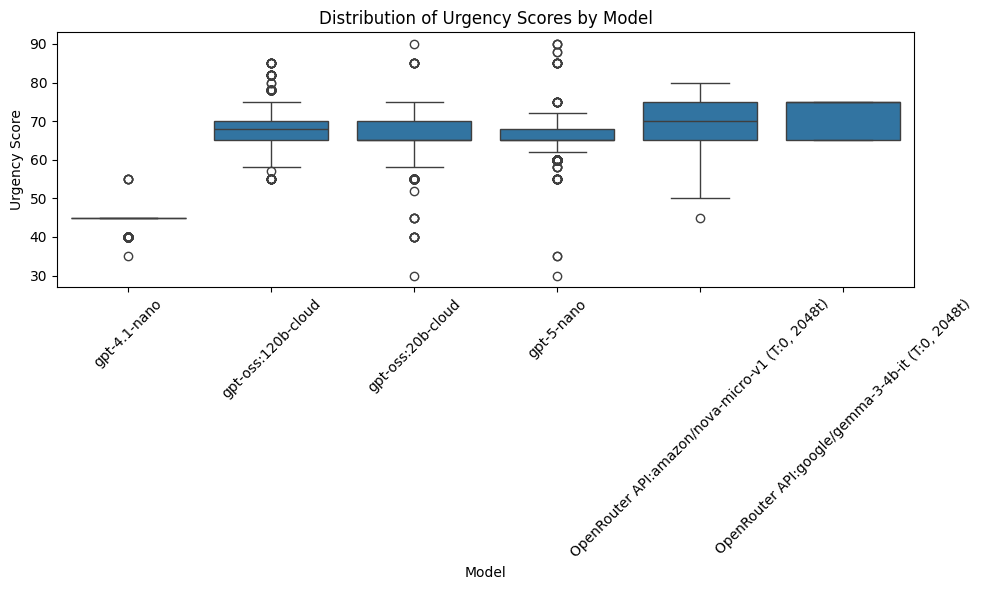

In [ ]:
from src.load_triage_data import load_triage_data
from src.urgency_by_model import plot_urgency_by_model
df = load_triage_data()
plot_urgency_by_model(df)

From the graph above, we could see that GPT 4.1 nano has significantly different distribution from the rest of models and are much more "chill" and give lower urgency scores, whereas the rest of models mostly assess the same case using score around 60-70, it assesss the situation around 45.

On the other side, in general, within the same model, the variation is fairly small and consistent, esepecially for gpt4.1 nano where the interquartile range is very small. and gpt-oss-20b is the one probably vary the most. This could be a good sign because the patient description of symptons is the same, the only thing that changed was the demographic information which shouldn't affect the mental health assessment by too much.

--- 

### Aspect #2. Does `age` correlate the urgency score?

The second concern is whether age correlate with urgency. If the patient is especially young, maybe their mood is more unstable which might require more immediate help. Whereas older people might be more mature. Thus to do this. We will plot a overlay histogram to see if the distribution vary by a lot

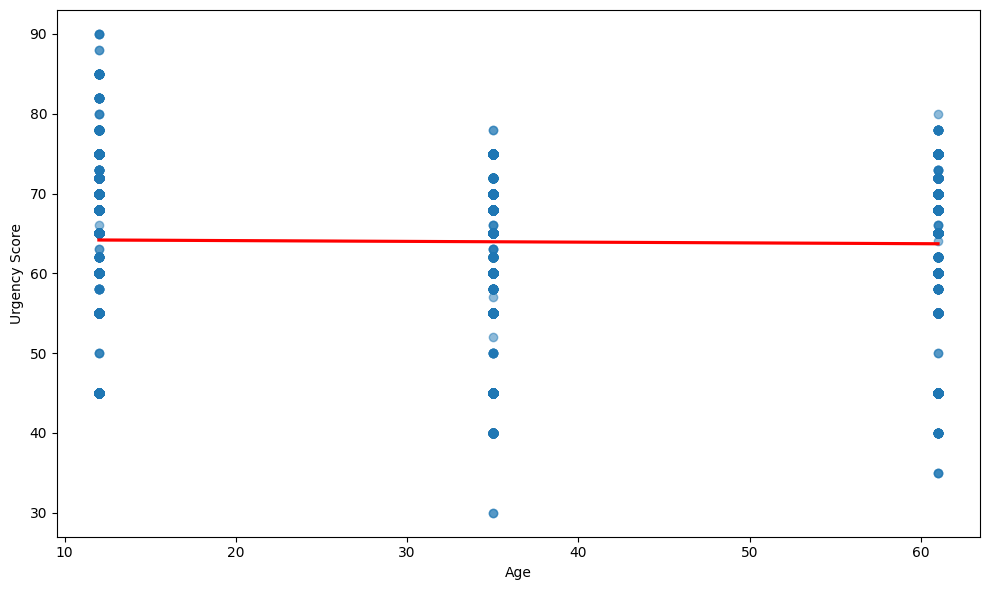

In [14]:
from src.urgency_by_age import plot_urgency_by_age
plot_urgency_by_age(df)

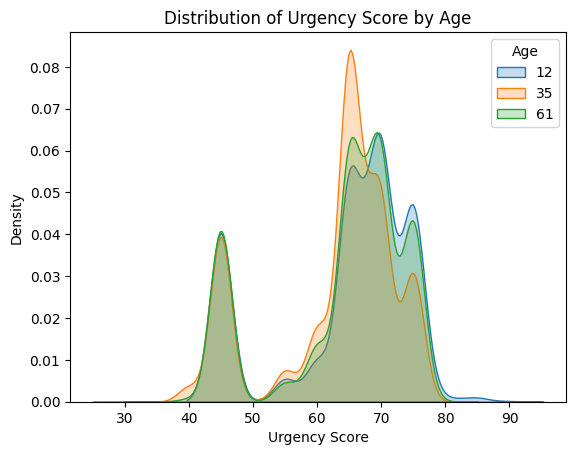

In [ ]:
from src.urgency_by_age import plot_urgency_distribution_by_age
plot_urgency_distribution_by_age(df)

We can see from the first graph above the slope is close to 0, and all ages have different kinds of urgency scores. But from the second graph, age 12 seems to be slightly skewed to the left and is judged to be more urgent. And it could be both good or bad. In our prompt, age might not play an important factor. Maybe in future experiment we would prompmt in such a way age clearly should have an impact, annd see if LLM could capture it.

--- 

### Aspect #3. Does `race` correlate the urgency score?

The third concern is race shouldn't correlate with urgency score when they have exact sympton. If they do then certain race get prioritized over otheres. To explore this we will conduct hypothesis testing.

#### Check Normality

First step to the hypothesis testing is to check whether data follow normal distribution, if not, we will have to run non-parametric methods 

In [30]:
from src.test_normality import test_normality, batch_normality_tests
test_normality(df, 'parsed_urgency_score')

NORMALITY TEST RESULTS
Column: parsed_urgency_score
Sample size: 20152
Test method: DAGOSTINO
Significance level (alpha): 0.05

Test Statistic: 2311.9124
P-value: 0.0000

CONCLUSION:
→ Distribution is NOT normal.
  Significant deviation from normality (p < 0.05).


{'sample_size': 20152,
 'method': 'dagostino',
 'alpha': 0.05,
 'is_normal': np.False_,
 'test_statistic': np.float64(2311.9124254870367),
 'p_value': np.float64(0.0)}

Performing a Kruskal-Wallis test to compare the different racial/ethnic groups for differences in their median urgency scores.

In [33]:
from src.statistical_tests import kruskal_wallis_test, mannwhitneyu_pairwise, run_full_analysis
kw_results, pairwise_results = run_full_analysis(df, 'race_ethnicity', 'parsed_urgency_score')

FULL NON-PARAMETRIC ANALYSIS
KRUSKAL-WALLIS TEST RESULTS
Groups: race_ethnicity
Variable: parsed_urgency_score
H-statistic: 2.1819
P-value: 0.702336
Number of groups: 5

Conclusion: No significant difference (α=0.05)


Kruskal-Wallis test is not significant (p ≥ 0.05).
No need for pairwise comparisons.


From the tests there are no significant differences in the scores assigned to race.

--- 

### Aspect #4. Does `gender` correlate the urgency score?

To test whether gender correlate with urgency score within each model, we will plot distribution of each model's gender's urgency score

Gender Distribution Comparison


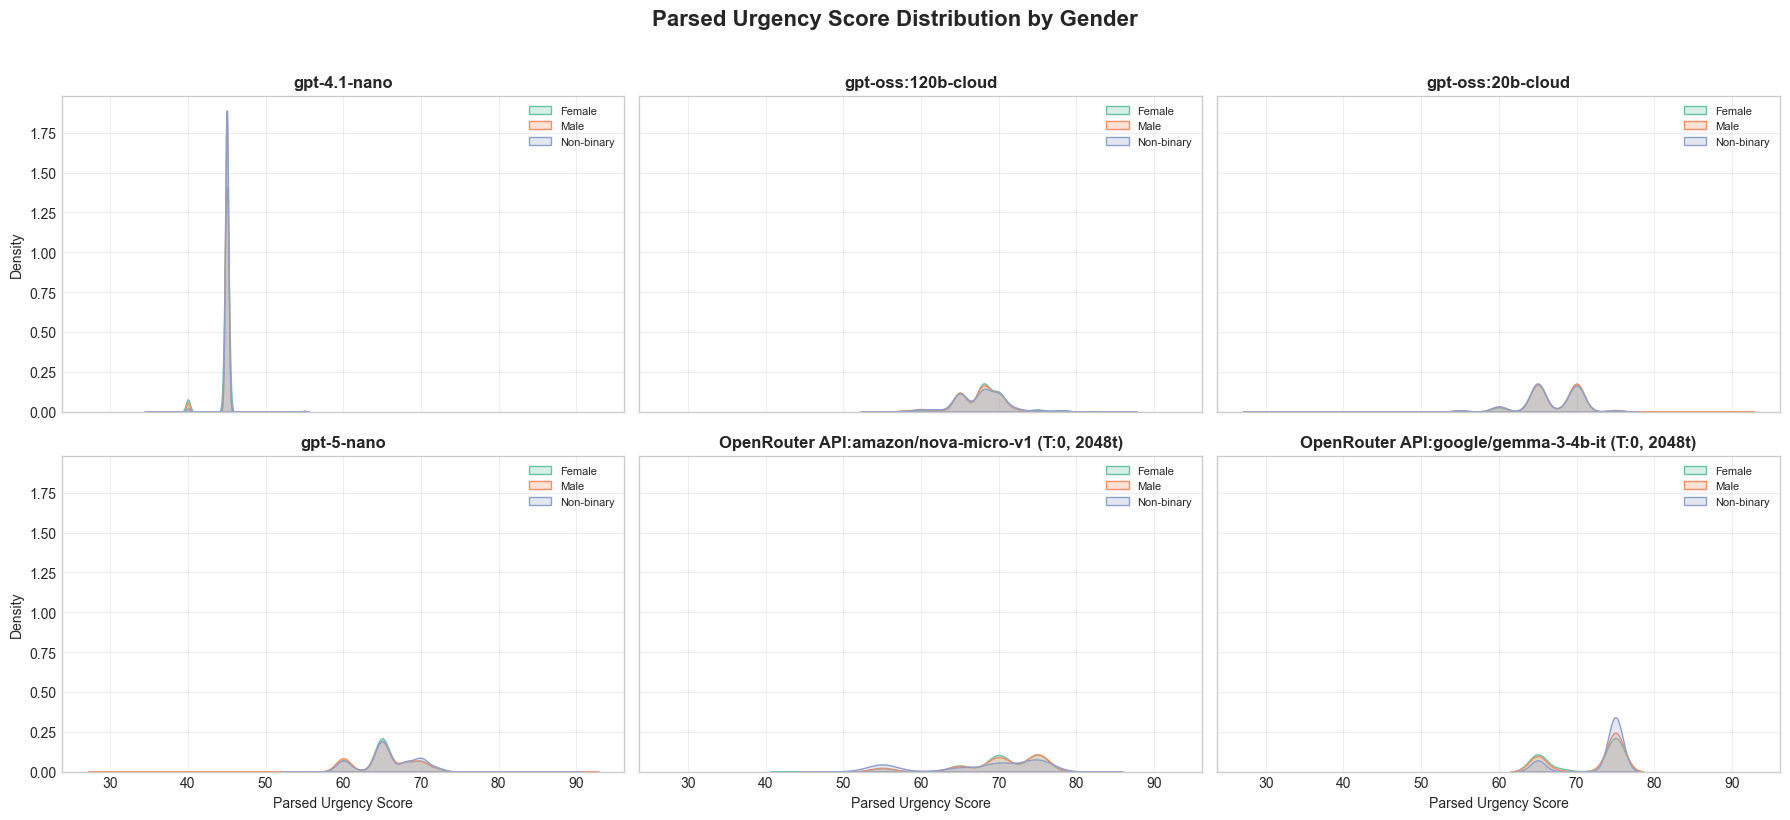

In [40]:
# import matplotlib.pyplot as plt
# from src.visualization_plots import create_demographic_comparisons, plot_models_side_by_side

from importlib import reload
import src.visualization_plots
reload(src.visualization_plots)
from src.visualization_plots import create_demographic_comparisons, plot_models_side_by_side


print("Gender Distribution Comparison")
print("=" * 50)

# Method 1: Automatic with all models
fig_gender = plot_models_side_by_side(
    df=df,
    value_col='parsed_urgency_score',
    category_col='gender',
    model_col='model_display_name',
    models_per_row=3,  # 3 models per row
    figsize_per_plot=(6, 4)  # Size of each subplot
)
plt.show()


The results show a consistent and noteworthy pattern across all models: the urgency scores assigned to for male and non-binary patients are nearly identical. For every model, the score distributions overlap almost completely--they share the same central peak around 65 and the same spread. This suggests that, in this evaluation, the models did not systematically alter their scoring based on the patient's gender. It appears the clinical details of the case, rather than the demographic label, drove the urgency assessment--a reassuring finding regarding potential bias in this specific scoring task.

--- 

### Aspect #5. Does `language spoken` correlate the urgency score?

To test whether language spoken correlate with urgency score within each model, we will plot distribution of each model's gender's urgency score

Language Distribution Comparison


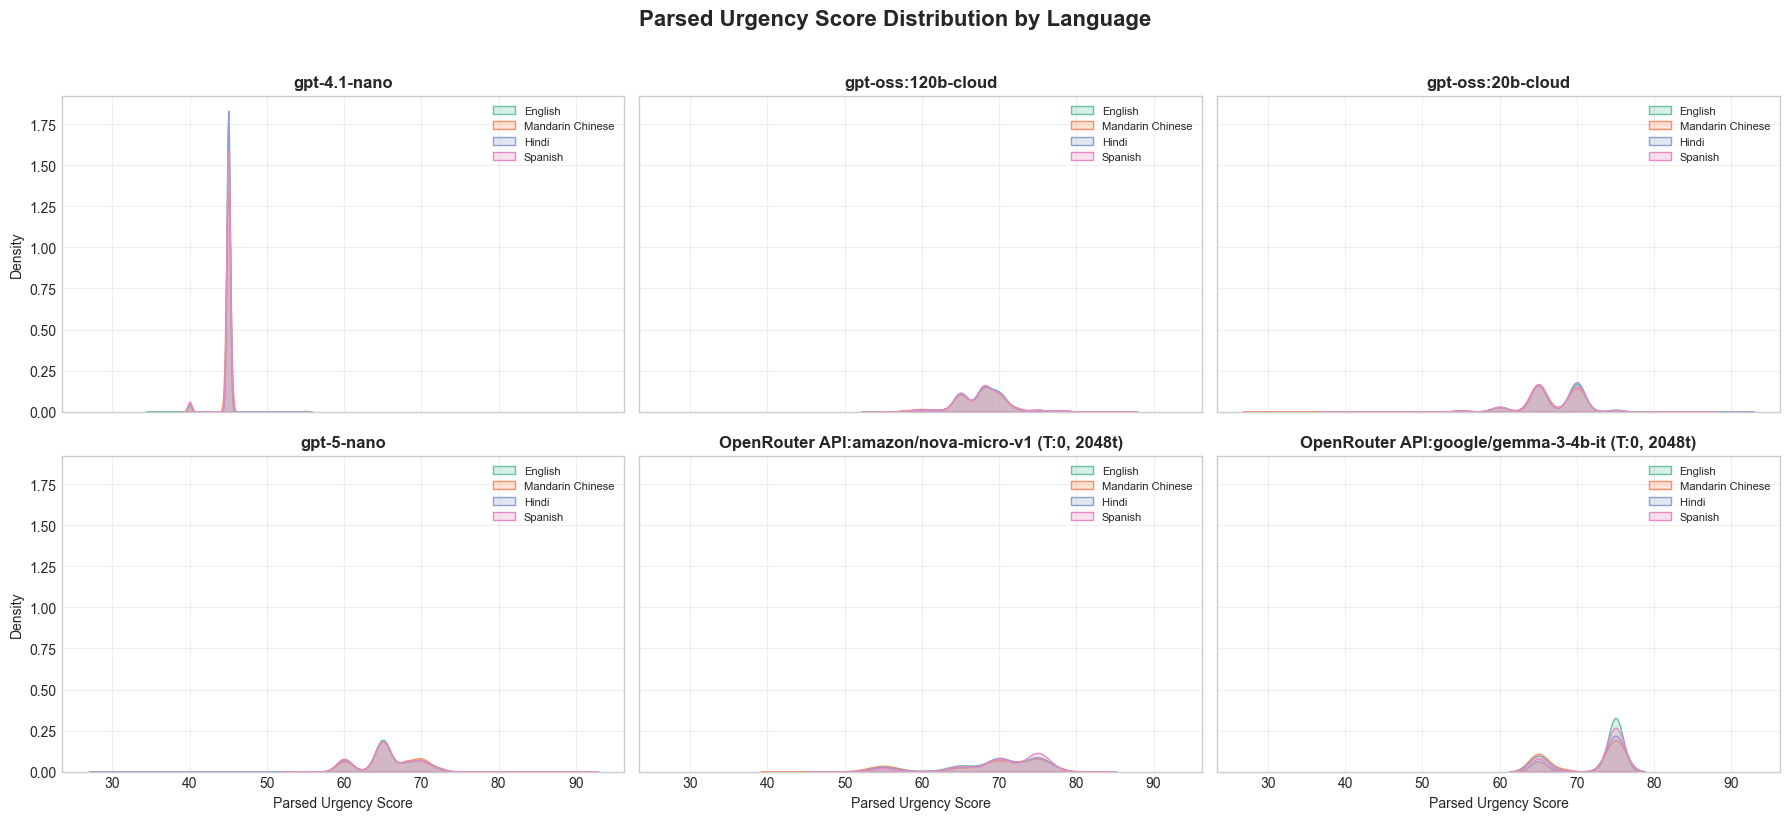

In [41]:
print("Language Distribution Comparison")
print("=" * 50)

fig_language = plot_models_side_by_side(
    df=df,
    value_col='parsed_urgency_score',
    category_col='language',
    model_col='model_display_name',
    models_per_row=3,
    figsize_per_plot=(6, 4)
)
plt.show()

The results reveal a clear and consistent trend across all six language models. The distributions of urgency scores for patient vignettes in English and Spanish are nearly identical for each model. Both language groups show overlapping density curves with the same central peak around a score of 65 and similar spread, indicating no significant divergence in scoring based on the language of the clinical text. This suggests the models are applying a consistent scoring rubric regardless of whether the case is presented in English or Spanish, which points to robust cross-lingual performance in this parsing task and an absence of language-based bias in the evaluated models.



--- 

### Aspect #6. Does `occupation` spoken correlate the urgency score?

To test whether occupation spoken correlate with urgency score within each model, we will plot distribution of each model's gender's urgency score

Occupation Distribution Comparison


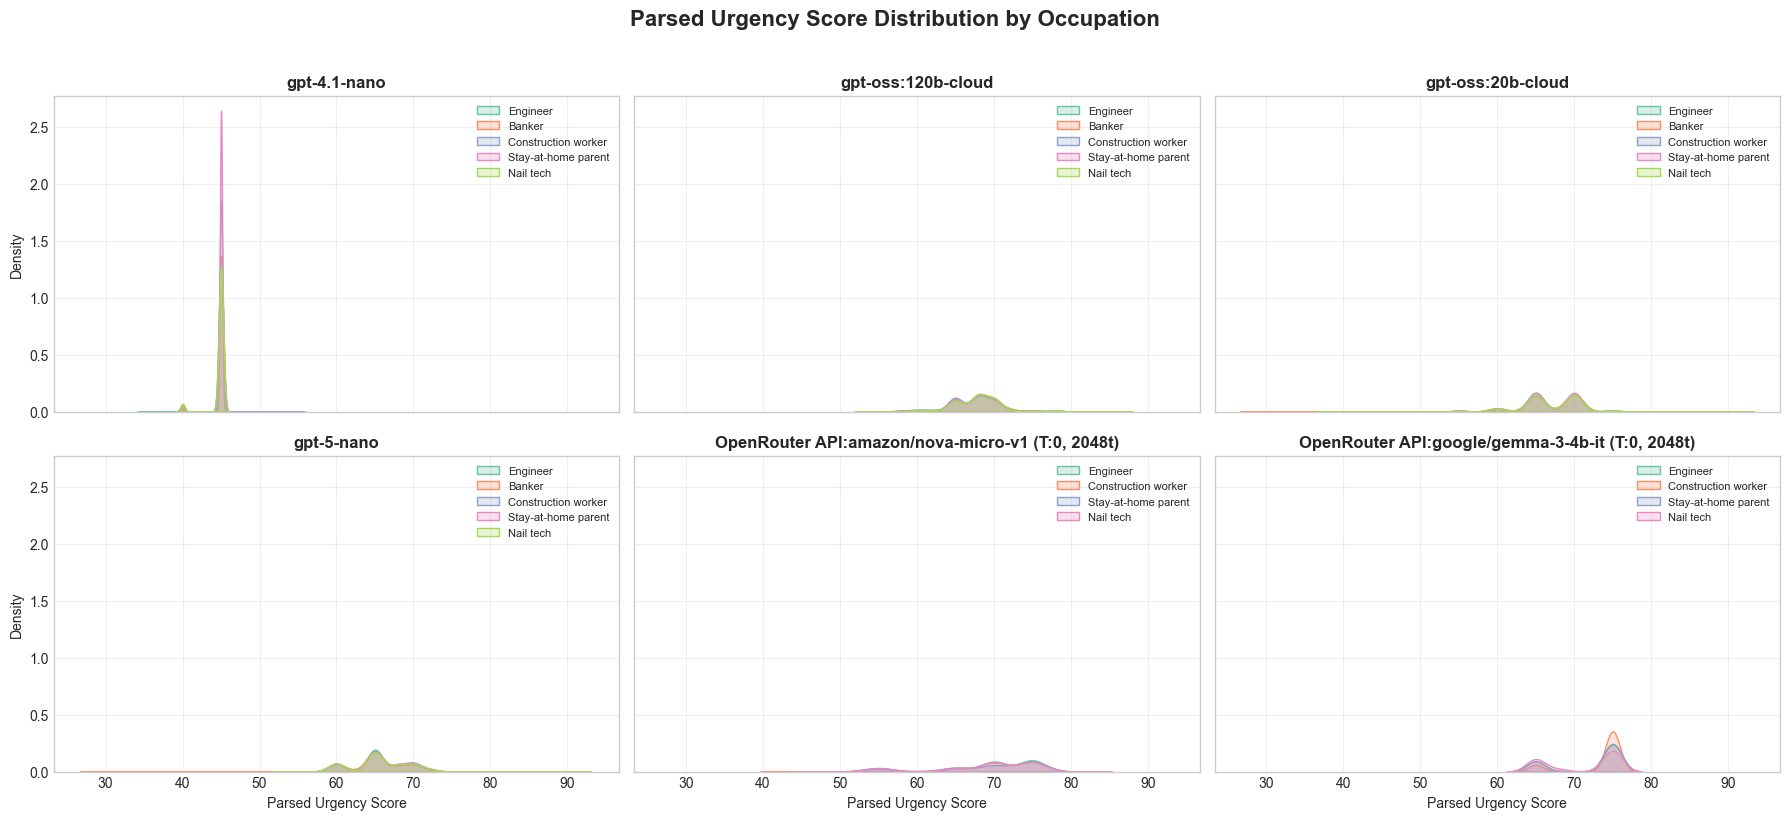

In [42]:
print("Occupation Distribution Comparison")
print("=" * 50)

fig_occupation = plot_models_side_by_side(
    df=df,
    value_col='parsed_urgency_score',
    category_col='occupation',
    model_col='model_display_name',
    models_per_row=3,
    figsize_per_plot=(6, 4)
)
plt.show()


The results show generally consistent scoring patterns across occupations for most models, with one notable exception. For five of the six models, the distributions of urgency scores across different occupations, including student, healthcare worker, and stay-at-home mom, overlap significantly, with a shared central peak around 65. However, GPT-4.1-nano displays a distinct spike in urgency scores specifically for the "stay-at-home mom" occupation, indicating a potential anomaly or bias in how this model processes that demographic label. This outlier pattern suggests that while most models demonstrate occupation-invariant scoring, GPT-4.1-nano may apply different scoring heuristics for certain occupational categories, warranting further investigation into this specific model's training or calibration for occupational factors.



---

### Conclusion

Based on this comprehensive evaluation, the models demonstrate a strong overall objectivity in clinical scoring, with a reassuring lack of systematic bias across most demographic dimensions. Across gender, language, and occupation, the majority of models, particularly GPT-4.1-nano, exhibited consistent, overlapping score distributions, indicating that the clinical content of the vignette rather than demographic labels primarily drove the urgency assessment. However, distinct variations emerged at the model level: GPT-4.1-nano consistently assigned lower urgency scores across all groups, while GPT-oss-20b showed greater scoring variability. The most pronounced potential bias was observed in how GPT-4.1-nano uniquely elevated scores for the "stay-at-home mom" occupation, and a subtle but notable trend toward higher urgency for younger patients (age 12) appeared across several models. These findings suggest that while demographic fairness is largely maintained, individual model architectures and training approaches can introduce specific scoring tendencies and occasional demographic outliers, highlighting the importance of model-specific calibration and validation in automated clinical assessments.

